## Import necassary libaries

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

## Tensorflow pipeline

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            'datasets2',
            shuffle = True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size=BATCH_SIZE)

Found 1839 files belonging to 5 classes.


In [9]:
dataset.class_names

['kohli', 'maria sharapova', 'messi', 'roger federer', 'serena williams']

In [6]:
len(dataset)*32

1856

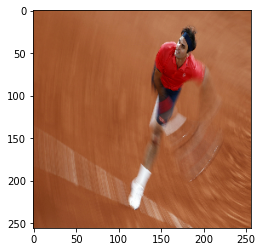

In [7]:
for batchsize,imagelabel in dataset.take(1):
    plt.imshow(batchsize[0].numpy().astype('uint8'))

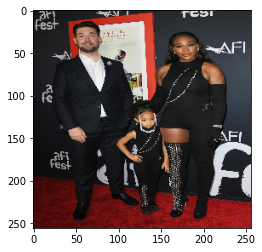

In [8]:
for image_batch,image_label in dataset.take(1):
    plt.imshow(image_batch[6].numpy().astype('uint8'))

In [10]:
class_names = dataset.class_names
class_names

['kohli', 'maria sharapova', 'messi', 'roger federer', 'serena williams']

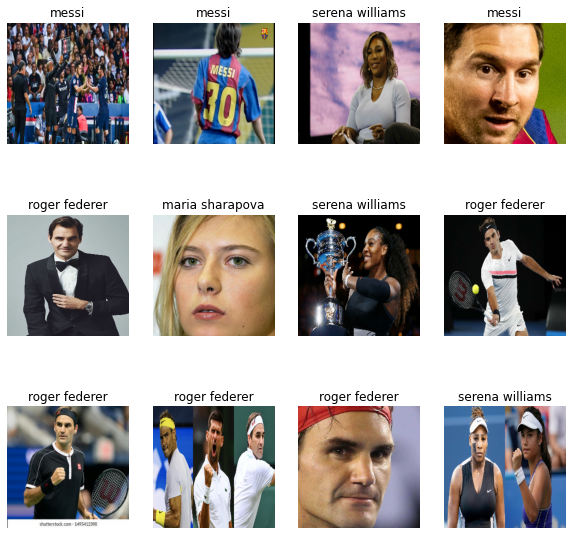

In [11]:
plt.figure(figsize=(10, 10))
for image_batch,image_label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[image_label[i]])
        plt.axis('off')

## Data splitting

In [12]:
def data_partition(df,train_size = 0.8,val_size = 0.1,test_size = 0.1,shuffle=True, shuffle_size=10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
    
    train = int(len(df)*train_size)
    val   = int(len(df)*val_size)
    
    train_ds = df.take(train)
    val_ds   = df.skip(train).take(val)
    test_ds  = df.skip(train).skip(val)
    
    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = data_partition(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
len(train_ds)

46

## Model building

In [17]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,MaxPool2D
from tensorflow.keras.models import Sequential

In [24]:
BATCH_SIZE,IMAGE_SIZE,CHANNELS

(32, 256, 3)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


model = tf.keras.models.Sequential([
        resize_and_rescale,
        data_augmentation,
        tf.keras.layers.Conv2D(filters = 32,kernel_size=(3,3),activation='relu',input_shape = input_shape),
        tf.keras.layers.MaxPool2D(2,2),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5,activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [32]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [33]:
model.fit(train_ds,validation_data=val_ds,batch_size=32,epochs=50)

Epoch 1/50


2022-09-07 20:35:23.803355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-07 20:35:28.816269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-07 20:35:29.021265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29 of 10000
2022-09-07 20:35:33.757287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-07 20:35:33.757337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-09-07 20:35:33.757469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-07 20:35:33.883635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.
2022-09-07 20:35:35.255607: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds

 1/46 [..............................] - ETA: 13:48 - loss: 1.6197 - accuracy: 0.3125

2022-09-07 20:35:35.967111: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.
2022-09-07 20:35:37.196286: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.


 2/46 [>.............................] - ETA: 1:20 - loss: 1.6215 - accuracy: 0.2656 

2022-09-07 20:35:37.792470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.


46/46 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.2144

2022-09-07 20:37:06.106406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-07 20:37:11.302657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 28 of 10000
2022-09-07 20:37:11.405319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-07 20:37:16.543527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-07 20:37:16.548985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-09-07 20:37:16.549085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


46/46 [==============================] - 122s 2s/step - loss: 1.6087 - accuracy: 0.2144 - val_loss: 1.6102 - val_accuracy: 0.1625
Epoch 2/50
15/46 [========>.....................] - ETA: 59s - loss: 1.5981 - accuracy: 0.2167 

KeyboardInterrupt: 

## Import trained models

In [1]:
from tensorflow.keras.models import load_model

In [3]:
model_1 = load_model('trained_models/model_1.h5')

In [4]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [17]:
model_1.evaluate(test_ds)

2022-09-19 16:37:08.328824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 10000
2022-09-19 16:37:08.928725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-19 16:37:11.640480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-09-19 16:37:13.573390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-09-19 16:37:13.584833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-09-19 16:37:13.584927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


7/7 [==============================] - 19s 474ms/step - loss: 0.5988 - accuracy: 0.8304


[0.5987575650215149, 0.8303571343421936]

In [20]:
model_2 = load_model('trained_models/model_2.h5')

In [31]:
model_2.evaluate(test_ds)

7/7 [==============================] - 3s 456ms/step - loss: 0.4836 - accuracy: 0.8750


[0.4835990369319916, 0.875]

In [24]:
model_3 = load_model('trained_models/model_3(best).h5')

In [25]:
model_3.evaluate(test_ds)

7/7 [==============================] - 3s 457ms/step - loss: 0.6837 - accuracy: 0.8616


[0.6836868524551392, 0.8616071343421936]

In [27]:
model_4 = load_model('trained_models/model_4(best01).h5')

In [28]:
model_4.evaluate(test_ds)

7/7 [==============================] - 3s 459ms/step - loss: 0.5935 - accuracy: 0.8661


[0.5934973359107971, 0.8660714030265808]

In [29]:
model_5 = load_model('trained_models/model_5(final).h5')

In [34]:
pd.DataFrame(model_5.evaluate(test_ds),columns=['model_5'])

7/7 [==============================] - 3s 454ms/step - loss: 0.8675 - accuracy: 0.8750


,model_5
0,0.867503
1,0.875000


### from these models model 2 is best

In [40]:
from tensorflow.keras.preprocessing import image

In [61]:
def prediction(target_file):
    test_images = image.load_img(target_file,target_size=(256,256))
    test_images = image.img_to_array(test_images)
    test_images = np.expand_dims(test_images,axis=0)
    return class_names[np.argmax(model_2.predict(test_images))]

In [57]:
test_images.shape

(1, 256, 256, 3)

In [58]:
np.argmax(model_2.predict(test_images))

1/1 [==============================] - 0s 31ms/step


2

In [59]:
class_names[np.argmax(model_2.predict(test_images))]

1/1 [==============================] - 0s 59ms/step


'messi'

In [62]:
prediction('/home/suhailpk/projects/classification_images/single_prediction/fcjoilwaiaamiej-1-1662651955.jpg')

1/1 [==============================] - 0s 37ms/step


'kohli'